<a href="https://colab.research.google.com/github/essat20/NLP_CW_210021102/blob/main/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting Up The IDE and importing the libraries Before Pre-processing

In [84]:
# downloading datasets
!pip install datasets # install the datasets from huggingface
!pip install transformers # used for the BERT model

In [85]:
# import the libraries

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
from datasets import load_dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW as aw

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt # this can be used to display loss/epoch graphs
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix # so i can display the confusion matrix

In [86]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# preparation
#!pip install datasets # install the datasets from huggingface
#!pip install transformers # used for the BERT model

# Load the dataset
dataset = load_dataset('emotion', trust_remote_code=True) # have to use the second parameter as there is required custom code for the dataset to be loaded properly


#Pre-processing the data

In [87]:
# Load the DistilBert tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Pre-processing the dataset

```
# This is formatted as code
```



The code below just defines the architecture the model architecture using a PyTorch neural network module. The SentimentClassifier class takes the DistilBERT model as input and defines the forward method. It extracts the last hidden state from the output of the DistilBERT model, and passes it through a linear layer to get the final logits.

In [88]:
# Define the model architecture
class SentimentClassifier(nn.Module):
    def __init__(self, model):
        super(SentimentClassifier, self).__init__()
        self.model = model
        self.linear = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]
        logits = self.linear(last_hidden_state)
        return logits.squeeze(-1)

# Instantiate the model
model = SentimentClassifier(model)


The code below now defines the training and eval loop. It sets the model to training mode and iterates through each batch of the training data. It calculates the loss, computes the gradients, and updates the model parameters using the AdamW optimizer.

In [95]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = dataset['train'].map(tokenize, batched=True)
test_dataset = dataset['test'].map(tokenize, batched=True)

# Set the data format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Set up the optimizer and loss function
optimizer = aw(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

# Define the training loop
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    loss_history = []  # Initialize an empty list to store loss values
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())  # Append the loss value to loss_history

    return loss_history  # Return the loss history after each epoch


# Define the evaluation loop
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.round(torch.sigmoid(outputs))

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    return correct / total

#Training the model

I was getting errors when running the BERT model.
I figured out that this was due to mismatch in the size of tensors at runtime within my dataset 'emotion'which comes from the sequences in my dataset having varying lengths.
To fix this issue i have to use a technique called 'padding' to normalise the length of the rows so they all match.
This technique could potentially cause a drop in performance of my model, in this situation it will likely cause a loss of context.

When running the model with 1 epoch, i got an accuracy of 0.347. This is quite low so I tested it again with epoch values 2 and 4 and got the same result.



tensor(119.3188, device='cuda:0', grad_fn=<DivBackward1>)
tensor(141.0725, device='cuda:0', grad_fn=<DivBackward1>)
tensor(133.8912, device='cuda:0', grad_fn=<DivBackward1>)
tensor(114.6803, device='cuda:0', grad_fn=<DivBackward1>)
tensor(147.0204, device='cuda:0', grad_fn=<DivBackward1>)
tensor(190.9910, device='cuda:0', grad_fn=<DivBackward1>)
tensor(154.2766, device='cuda:0', grad_fn=<DivBackward1>)
tensor(156.0138, device='cuda:0', grad_fn=<DivBackward1>)
tensor(166.9435, device='cuda:0', grad_fn=<DivBackward1>)
tensor(155.9194, device='cuda:0', grad_fn=<DivBackward1>)
tensor(156.8618, device='cuda:0', grad_fn=<DivBackward1>)
tensor(178.0786, device='cuda:0', grad_fn=<DivBackward1>)
tensor(125.2843, device='cuda:0', grad_fn=<DivBackward1>)
tensor(103.6724, device='cuda:0', grad_fn=<DivBackward1>)
tensor(189.3535, device='cuda:0', grad_fn=<DivBackward1>)
tensor(180.4189, device='cuda:0', grad_fn=<DivBackward1>)
tensor(163.3142, device='cuda:0', grad_fn=<DivBackward1>)
tensor(107.504

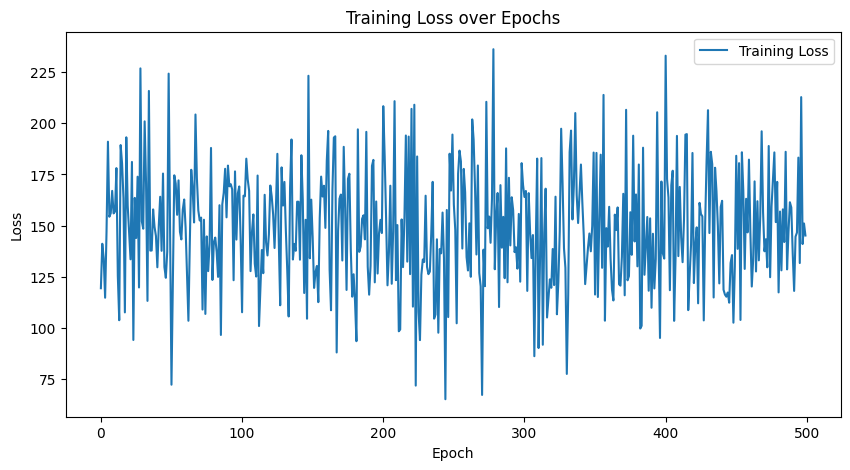

In [98]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# pad the sequences
def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  labels = [item['label'] for item in batch]

  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  attention_mask = pad_sequence(attention_mask,batch_first=True,padding_value=0)

  return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'label': torch.tensor(labels)
  }

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle = False, collate_fn = collate_fn)


#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

loss_history = []  # Initialize loss_history

# Train the model
for epoch in range(1):
    #loss_history = []  # Initialize loss_history
    loss_history += train(model, train_loader, optimizer, loss_fn, device)  # Update loss_history for each epoch
    #loss_history.extend(epoch_loss)
    accuracy = evaluate(model, test_loader, device)
    print(f'Epoch {epoch+1} - Test Accuracy: {accuracy:.3f}')

    # Compute predictions
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.round(torch.sigmoid(outputs))

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot loss/epoch graph
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()


# Plotting the loss/epoch graph

In [ ]:
# Plot loss/epoch graph
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()